In [20]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.vector_ar.irf import IRAnalysis
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [21]:
# # Step 1: Dataframe creation and definitions
# Select the relevant variables
df = pd.read_excel("quant-test.xlsm", index_col=0)
variables = list(df.columns)#['Brent_m1', 'margin_m3', 'US_5YR_BE', 'FUT_AGGTE_VOL']
response = variables[0]
var_list = variables[1:]

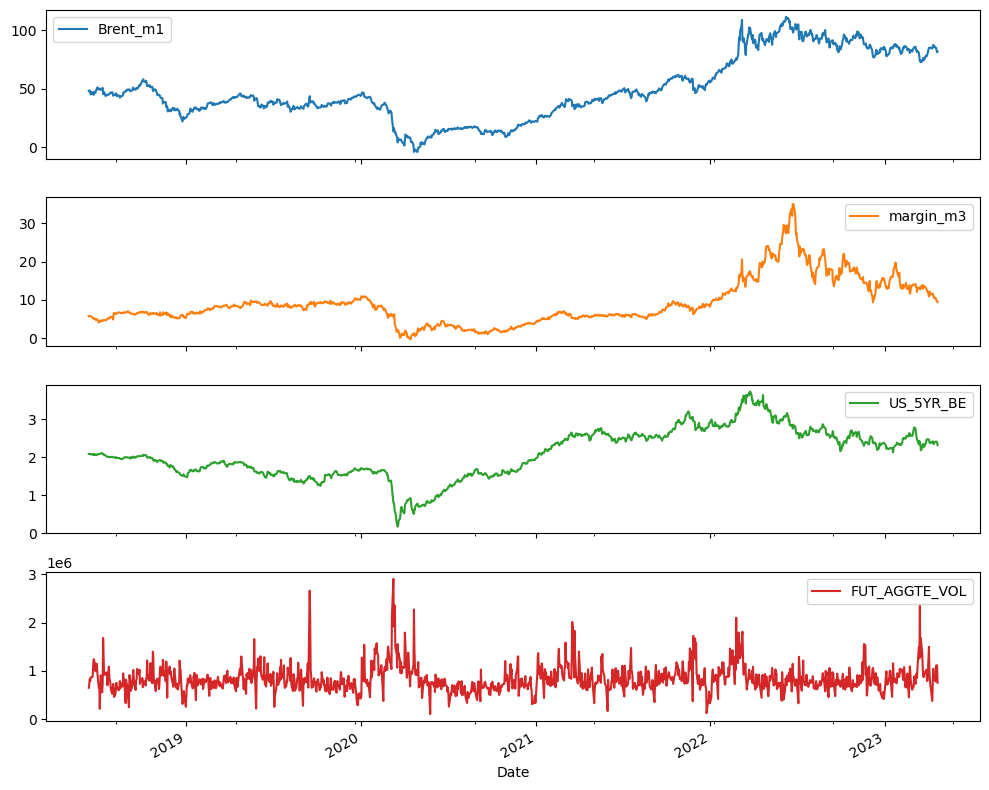

In [22]:
# Step 2: Preprocessing and exploratory data analysis
data = df.dropna()  # Remove rows with missing values
data.plot(subplots=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

In [23]:
# Step 3: Testing using Granger's Causality test
# tests if past values in series x cause series y
# null hypothesis: coefs of past values in regression equation is zero
# using a significance level of 0.05, if p value less than 0.05: reject null hypothesis
# if pval<0.05, there is evidence that the variables are causing each other
def grangers_matrix(data, variables, test='ssr_chi2test'):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for col in df.columns:
        for row in df.index:
            test_result = grangercausalitytests(data[[row, col]].pct_change().dropna(), maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[row, col] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

maxlag=10
grangers_matrix(data, data.columns, test='ssr_chi2test')

,Brent_m1_x,margin_m3_x,US_5YR_BE_x,FUT_AGGTE_VOL_x
Brent_m1_y,1.0000,0.0000,0.0000,0.4779
margin_m3_y,0.0000,1.0000,0.0000,0.4129
US_5YR_BE_y,0.0044,0.0000,1.0000,0.5039
FUT_AGGTE_VOL_y,0.3212,0.6236,0.5546,1.0000


In [24]:
# Step 4: Split into train and test
# taking 10 data points for testing and the rest for training
n = 10
train_data, test_data = data[:-n], data[-n:]

In [25]:
# Step 5: Check for stationarity and convert
# done using the ADF Test (Augmented Dickey-Fuller Test)
# if non-stationary, take the difference of the series until it becomes stationary
def adf_test(df):
    for col in df.columns:

        sig_level = 0.05

        adf = adfuller(df[col].values,autolag='AIC')
        p_val = adf[1]

        if p_val <= sig_level:
            print(f"\npvalue = {p_val}, null hypothesis rejected")
            print(f"{col} is stationary")
        else:
            print(f"\npvalue = {p_val}, null hypothesis not rejected")
            print(f"{col} is non-stationary") 

adf_test(train_data)   
train_data_diff =  train_data.diff().dropna()
adf_test(train_data_diff) 


pvalue = 0.8645150358383398, null hypothesis not rejected
Brent_m1 is non-stationary

pvalue = 0.40690998456474947, null hypothesis not rejected
margin_m3 is non-stationary

pvalue = 0.5799586074440188, null hypothesis not rejected
US_5YR_BE is non-stationary

pvalue = 8.907691584291495e-09, null hypothesis rejected
FUT_AGGTE_VOL is stationary

pvalue = 7.551479737876745e-29, null hypothesis rejected
Brent_m1 is stationary

pvalue = 1.7563741826279875e-12, null hypothesis rejected
margin_m3 is stationary

pvalue = 0.0, null hypothesis rejected
US_5YR_BE is stationary

pvalue = 1.3937840569924107e-23, null hypothesis rejected
FUT_AGGTE_VOL is stationary


In [26]:
# Step 6: Select order to minimise AIC
model = VAR(train_data_diff)
lst = []
for i in list(range(1,100)):
    result = model.fit(i)
    lst.append(result.aic)   
lag_order_aic = np.argmin(lst) + 1

In [27]:
# Step 7: Train model
model_fit = model.fit(lag_order_aic)
# model_fit.summary()

In [28]:
# Step 8: Forecast
lag_order = model_fit.k_ar
forecast_input = train_data_diff
fc = model_fit.forecast(y=forecast_input.values, steps=lag_order)
data_forecast = pd.DataFrame(fc,index=test_data.index[-lag_order:], columns=data.columns)

In [29]:
# Step 9: Reverse the differencing
data_fc = data_forecast.copy()
columns = train_data.columns
for col in columns:
    # Roll back difference
    data_fc[col] = train_data[col].iloc[-1] + data_fc[col].cumsum()
    
data_fc.columns = [col+"_forecast" for col in columns]

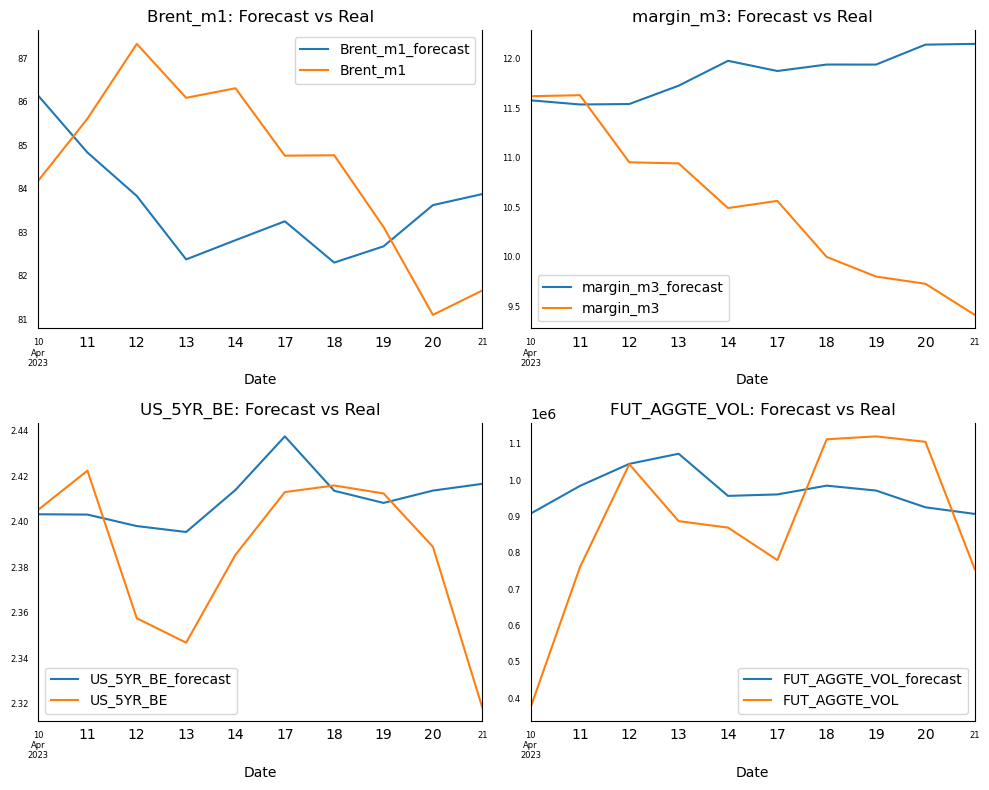

In [30]:
# Step 10: Plots
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=100, figsize=(10,8))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    data_fc[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test_data[col][-n:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Real")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [31]:
# Step 11: Metrics
for i,j in zip(df.columns,data_fc.columns):
    if i in j:
        mape = np.mean(np.abs(data_fc[j] - test_data[i])/np.abs(test_data[i]))
        mpe = np.mean((data_fc[j] - test_data[i])/test_data[i])
        rmse = np.mean((data_fc[j] - test_data[i])**2)**0.5
        print(f"For variable: {i}")
        print(f"mape = {mape}\nmpe  = {mpe}\nrmse = {rmse}\n")

For variable: Brent_m1
mape = 0.026659158013999585
mpe  = -0.0103432269410384
rmse = 2.5007061354864772

For variable: margin_m3
mape = 0.13524349679292233
mpe  = 0.13292582092552846
rmse = 1.6280322968785832

For variable: US_5YR_BE
mape = 0.012401438884995408
mpe  = 0.010112518346929361
rmse = 0.04004769752719643

For variable: FUT_AGGTE_VOL
mape = 0.2869834921024275
mpe  = 0.20485544984781554
rmse = 224148.5896335785

